## IN THIS NOTEBOOK WE HANDLE THE RULES TO MAKE DECISIONS ABOUT CONTRACTS AND THE MONTECARLO SIMULATIONS
A rule is defined in our framework as a mapping between an input data x = (x1,x2,...,xM) to the decision y that is contained in the set (accepted, rejected, accepted with extra charge, need for additional information)
Specifically we store all the N rules in a table with N rows and M+1 columns, where the last column contains the decision y. 
The input values x1,...,xM are different in nature and can be for example:
discrete variable, such as the age or BMI, taking discrete values between 1 and 100
binary variables, have you smoked in the last 12 months?: True or False 

In this setting when processing a new input data (x1,x2,...,xM) we need to first match it with the current entries in the table, if a current rule matches the input perfectly, then we return y correponding to that rule. If there is no perfect rule, then we have to match the input value with the closest rule in the current set of rules. 
Given the variablity in the input arguments variables (categorigal, bool, ...) we need to have use a similatity metric that is able to handle them and aggregate them. 

Once the most similar rule (row) is selected, then the y corresponding to that line is returned.

Then we have a set of operational rules, that we will model as another mapping function (x1,...,xM) => y this time we need instead of a table, an analytical function that gives the correct decision for each input. This is the optimal set of rules, that we are trying to learn overtime.

For starting we will work with just M=4 and the variables are BMI, AGE, SMOKER?, PRACTICE_SPORT?
I want you to generate some rules, and the operational rules, and store them into pd dataframes, then I need you to generate the similarity function to retrieve the best rule.


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm  # progress bar
import matplotlib.pyplot as plt
from helpers import sample_population

# --------------------------------------------------
# 1. Initial Setup
# --------------------------------------------------
LEARN_FLAG = True  # Global variable controlling self-learning

columns = ['BMI', 'AGE', 'SMOKER', 'PRACTICE_SPORT', 'DECISION', 'COMMENT']

rules_data = [
    [22, 25, False, True,  "accepted", "nothing special, young healthy non-smoker practicing sport"],
    [30, 45, True,  False, "accepted with extra charge", "smoker with moderate BMI, increased premium risk"],
    [27, 35, False, False, "need for additional information", "unclear risk profile, needs more info"],
    [35, 55, True,  False, "rejected", "rejected because of too high risk due to age and smoking"],
    [19, 20, False, True,  "accepted", "nothing special, fit young individual"],
    [25, 40, True,  True,  "accepted with extra charge", "smoker despite doing sports, small surcharge"]
]

rules_df = pd.DataFrame(rules_data, columns=columns)


# --------------------------------------------------
# 2. Operational Analytical Rule
# --------------------------------------------------
def operational_rule(BMI, AGE, SMOKER, PRACTICE_SPORT):
    # --- Hard rejections ---
    if AGE > 85:
        return "rejected", "very high age (86+ years)"
    if BMI > 45:
        return "rejected", "morbid obesity (BMI > 45)"
    if BMI < 14 and AGE < 18:
        return "rejected", "severely underweight minor (BMI < 14)"
    if BMI < 16 and AGE >= 18:
        return "rejected", "severe underweight adult (BMI < 16)"
    if SMOKER and BMI > 35:
        return "rejected", "obese smoker (BMI > 35)"
    if SMOKER and AGE > 67 and not PRACTICE_SPORT:
        return "rejected", "aged smoker without sport"

    # --- Adolescents ---
    if AGE < 18:
        if BMI < 16 or BMI > 30:
            return "need for additional information", "BMI outside healthy adolescent range"
        else:
            return "accepted", "healthy adolescent profile"

    # --- Very healthy older adults (lenient rule for 60–85) ---
    if AGE <= 85 and AGE > 60 and not SMOKER and PRACTICE_SPORT and 18.5 <= BMI <= 30:
        return "accepted with extra charge", "healthy older adult (60–85), active and good BMI"

    if AGE > 75 and not PRACTICE_SPORT:
        return "rejected", "older adult (>=76), not active"
    # --- Extra charge rules ---
    if SMOKER and BMI > 25:
        return "accepted with extra charge", "smoker with overweight BMI"
    if SMOKER and AGE > 60:
        return "accepted with extra charge", "older smoker"
    if 35 <= BMI <= 45:
        return "accepted with extra charge", "obese (BMI 35–45)"
    if BMI < 18.5:
        return "accepted with extra charge", "underweight adult"
    if AGE >= 70 and not SMOKER:
        return "accepted with extra charge", "advanced age (70+)"
    if PRACTICE_SPORT == False and BMI > 30:
        return "accepted with extra charge", "inactive overweight"

    # --- Need more info for specific age/BMI combos ---
    if 65 <= AGE < 70:
        return "need for additional information", "age between 65–70, require medical exam"
    if 18 <= AGE <= 25 and (BMI < 18.5 or BMI > 30):
        return "need for additional information", "unusual BMI for young adult"

    # --- Default acceptance ---
    if (18.5 <= BMI <= 30) and (AGE <= 60) and not SMOKER and PRACTICE_SPORT:
        return "accepted", "healthy BMI, non-smoker, active, age ≤ 60"
    if (18.5 <= BMI <= 30) and (AGE <= 60) and not SMOKER:
        return "accepted", "healthy BMI, non-smoker, age ≤ 60"

    # --- Catch-all ---
    return "accepted with extra charge", "moderate risk profile, no major issues"



# --------------------------------------------------
# 3. Similarity Function
# --------------------------------------------------
def compute_similarity(row, x_input, w_num=1.0, w_cat=1.0):
    sim = 0
    sim += w_num * (1 - abs(row['BMI'] - x_input['BMI']) / 100)
    sim += w_num * (1 - abs(row['AGE'] - x_input['AGE']) / 100)
    sim += w_cat * (1 if row['SMOKER'] == x_input['SMOKER'] else 0)
    sim += w_cat * (1 if row['PRACTICE_SPORT'] == x_input['PRACTICE_SPORT'] else 0)
    return sim


def find_best_rule(rules_df, x_input):
    similarities = rules_df.apply(lambda r: compute_similarity(r, x_input), axis=1)
    best_idx = similarities.idxmax()
    best_rule = rules_df.loc[best_idx]
    return best_rule, similarities[best_idx]


# --------------------------------------------------
# 4. Decision + Learning Logic (with comments)
# --------------------------------------------------
def decide_and_learn(rules_df, x_input):
    """
    Decide the output for a given input and optionally update the rules table,
    now including a COMMENT explaining the reason for the decision.
    """
    global LEARN_FLAG

    # 1. Compute the ideal decision and comment
    operational_decision, operational_comment = operational_rule(
        x_input['BMI'], x_input['AGE'], x_input['SMOKER'], x_input['PRACTICE_SPORT']
    )

    # 2. Find the closest rule in the current table
    best_rule, similarity = find_best_rule(rules_df, x_input)

    # 3. Check for a perfect match
    perfect_match = (
        (best_rule['BMI'] == x_input['BMI']) and
        (best_rule['AGE'] == x_input['AGE']) and
        (best_rule['SMOKER'] == x_input['SMOKER']) and
        (best_rule['PRACTICE_SPORT'] == x_input['PRACTICE_SPORT'])
    )

    if perfect_match:
        decision = best_rule['DECISION']
        # If decision differs from operational, update
        if decision != operational_decision and LEARN_FLAG:
            rules_df.loc[best_rule.name, ['DECISION', 'COMMENT']] = [operational_decision, operational_comment]
            decision = operational_decision
    else:
        # Use the closest rule's decision (which may be wrong)
        decision = best_rule['DECISION']

        # Learn new rule if enabled
        if LEARN_FLAG:
            new_rule = {
                'BMI': x_input['BMI'],
                'AGE': x_input['AGE'],
                'SMOKER': x_input['SMOKER'],
                'PRACTICE_SPORT': x_input['PRACTICE_SPORT'],
                'DECISION': operational_decision,
                'COMMENT': operational_comment
            }
            rules_df.loc[len(rules_df)] = new_rule

    return decision, operational_decision, rules_df


Simulating: 100%|██████████| 10000/10000 [03:29<00:00, 47.69it/s]


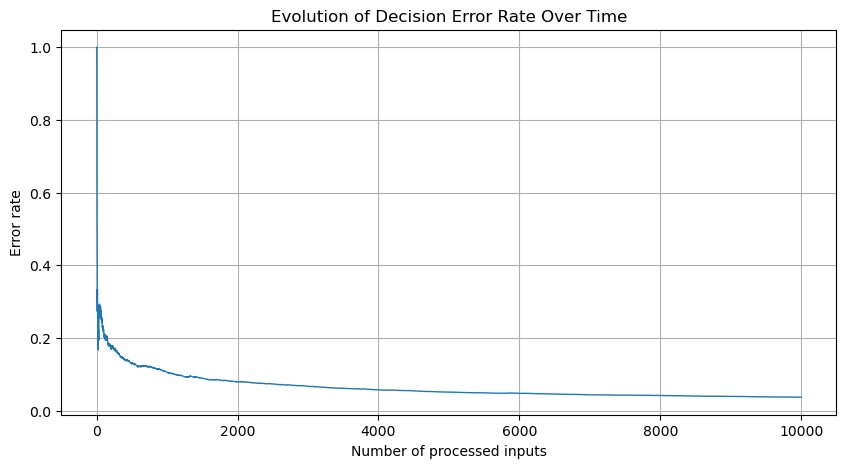

Final error rate after 10000 samples: 0.0366
Total rules learned: 8587


In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar

# --------------------------------------------------
# 6. Simulation
# --------------------------------------------------
np.random.seed(42)
n_samples = 10000
# Generate realistic population sample
population_df = sample_population(n_samples=n_samples, seed=42)

# Only keep the features needed for the simulation
inputs = population_df[['BMI', 'AGE', 'SMOKER', 'PRACTICE_SPORT']].copy()

error_history = []
false_decisions = 0

# Use tqdm to wrap the iteration
for i, row in tqdm(inputs.iterrows(), total=n_samples, desc="Simulating"):
    x_input = row.to_dict()
    decision, ideal, rules_df = decide_and_learn(rules_df, x_input)
    if decision != ideal:
        false_decisions += 1
    error_rate = false_decisions / (i + 1)
    error_history.append(error_rate)

# --------------------------------------------------
# 7. Plot Error Evolution
# --------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(error_history, linewidth=1)
plt.xlabel("Number of processed inputs")
plt.ylabel("Error rate")
plt.title("Evolution of Decision Error Rate Over Time")
plt.grid(True)
plt.show()

print(f"Final error rate after {n_samples} samples: {error_history[-1]:.4f}")
print(f"Total rules learned: {len(rules_df)}")


In [ ]:
# Optionally you can store the lerned rules, we use these as our official set of rules!
#rules_df.to_csv("../../assets/learned_rules.csv")

Simulating: 100%|██████████| 10000/10000 [02:16<00:00, 73.49it/s]


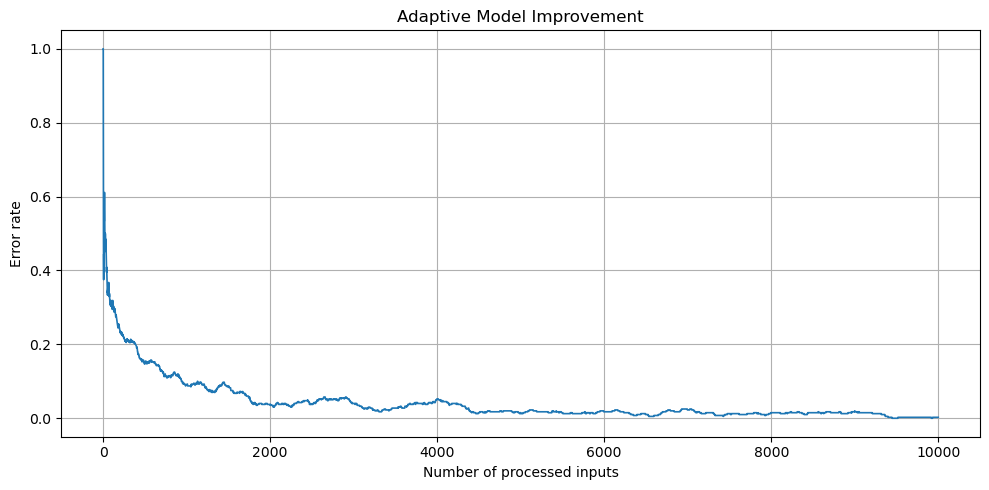

Final rolling error rate (last 400 samples): 0.0025
Total rules learned: 4427


In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------------------------------
# 6. Simulation
# --------------------------------------------------
np.random.seed(42)
n_samples = 10000

rules_data = [
    [22, 25, False, True,  "accepted", "nothing special, young healthy non-smoker practicing sport"],
    [30, 45, True,  False, "accepted with extra charge", "smoker with moderate BMI, increased premium risk"],
    [27, 35, False, False, "need for additional information", "unclear risk profile, needs more info"],
    [35, 55, True,  False, "rejected", "rejected because of too high risk due to age and smoking"],
    [19, 20, False, True,  "accepted", "nothing special, fit young individual"],
    [25, 40, True,  True,  "accepted with extra charge", "smoker despite doing sports, small surcharge"]
]

rules_df = pd.DataFrame(rules_data, columns=columns)

# Generate random inputs
inputs = pd.DataFrame({
    'BMI': np.random.randint(15, 40, n_samples),
    'AGE': np.random.randint(18, 70, n_samples),
    'SMOKER': np.random.choice([True, False], n_samples),
    'PRACTICE_SPORT': np.random.choice([True, False], n_samples)
})

error_flags = []

for i, row in tqdm(inputs.iterrows(), total=n_samples, desc="Simulating"):
    x_input = row.to_dict()
    decision, ideal, rules_df = decide_and_learn(rules_df, x_input)
    error_flags.append(1 if decision != ideal else 0)

# --------------------------------------------------
# 7. Rolling Error Rate (adaptive)
# --------------------------------------------------
window_size = 400
# Compute rolling mean, allowing smaller windows at the start
rolling_error = pd.Series(error_flags).rolling(window=window_size, min_periods=1).mean()

# --------------------------------------------------
# 8. Plot Error Evolution
# --------------------------------------------------
plt.figure(figsize=(10, 5))

# Remove the first data point (index 0)
rolling_error_trimmed = rolling_error.iloc[1:]

plt.plot(rolling_error_trimmed.index, rolling_error_trimmed.values, linewidth=1.2)
plt.xlabel("Number of processed inputs")
plt.ylabel(f"Error rate")
plt.title("Adaptive Model Improvement")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final rolling error rate (last {window_size} samples): {rolling_error_trimmed.iloc[-1]:.4f}")
print(f"Total rules learned: {len(rules_df)}")

# REALISTIC SAMPLING FOR MONTE CARLO ANALYISIS
We need to sample randomly from the population but that's not an easy task.
We use the data from: https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.blv.admin.ch/dam/blv/fr/dokumente/lebensmittel-und-ernaehrung/ernaehrung/menuch-bericht.pdf.download.pdf/Anthropometric%2520characteristics%2520and%2520indicators%2520of%2520%2520eating%2520and%2520physical%2520activity%2520behaviors%2520%2520in%2520the%2520Swiss%2520adult%2520population%25202014-2015.pdf&ved=2ahUKEwikl96WltGQAxU84gIHHW4cDZEQFnoECB4QAQ&usg=AOvVaw21dyUZ4fA763tjkX5ZueNY

to get inspiration for our sampling function. This gives an ultra-realistic sampling from the swiss population based on factual data.

In [8]:
import numpy as np
import pandas as pd

def sample_population(n_samples=10_000, seed=42):
    """
    Generate a realistic Swiss population sample (all ages) 
    based on menuCH data and Swiss demographics.

    Returns:
        DataFrame with columns:
        ['AGE', 'SEX', 'HEIGHT_CM', 'WEIGHT_KG', 'BMI', 'SMOKER', 'PRACTICE_SPORT']
    """
    np.random.seed(seed)

    # -------------------------------------------------------------------------
    # 1. Swiss population age distribution (source: Swiss Federal Statistics)
    # -------------------------------------------------------------------------
    # Total adds up to 1.0
    age_groups = {
        '0-19': 0.20,
        '20-64': 0.60,
        '65-79': 0.14,
        '80+': 0.06
    }

    # Sex ratio roughly 50/50
    sex_categories = ['Male', 'Female']
    sex_probs = [0.5, 0.5]

    # -------------------------------------------------------------------------
    # 2. Sample age (continuous within each group)
    # -------------------------------------------------------------------------
    ages = []
    for _ in range(n_samples):
        group = np.random.choice(list(age_groups.keys()), p=list(age_groups.values()))
        if group == '0-19':
            ages.append(np.random.randint(0, 20))
        elif group == '20-64':
            ages.append(np.random.randint(20, 65))
        elif group == '65-79':
            ages.append(np.random.randint(65, 80))
        else:
            ages.append(np.random.randint(80, 95))
    ages = np.array(ages)

    # -------------------------------------------------------------------------
    # 3. Assign sex
    # -------------------------------------------------------------------------
    sexes = np.random.choice(sex_categories, size=n_samples, p=sex_probs)

    # -------------------------------------------------------------------------
    # 4. Anthropometrics (data driven, depends on sex and age)
    # -------------------------------------------------------------------------
    height = np.zeros(n_samples)
    weight = np.zeros(n_samples)
    bmi = np.zeros(n_samples)

    for i, sex in enumerate(sexes):
        age = ages[i]

        # Children & adolescents
        if age < 20:
            if sex == 'Male':
                height[i] = np.random.normal(165 if age > 15 else 150, 10)
                bmi[i] = np.random.normal(20 if age > 15 else 18, 2.5)
            else:
                height[i] = np.random.normal(160 if age > 15 else 145, 10)
                bmi[i] = np.random.normal(19 if age > 15 else 17.5, 2.5)

        # Adults
        elif age < 65:
            if sex == 'Male':
                bmi_mean = 25.0 if age < 50 else 25.9
                bmi_sd = 3.8
                height[i] = np.random.normal(178, 7.5)
            else:
                bmi_mean = 23.8 if age < 50 else 24.5
                bmi_sd = 4.0
                height[i] = np.random.normal(165, 6.5)
            bmi[i] = np.random.normal(bmi_mean, bmi_sd)

        # Seniors (65+)
        else:
            if sex == 'Male':
                bmi[i] = np.random.normal(26.0, 3.5)
                height[i] = np.random.normal(173, 7.0)
            else:
                bmi[i] = np.random.normal(25.0, 3.8)
                height[i] = np.random.normal(160, 6.0)

        # Compute weight
        weight[i] = bmi[i] * (height[i] / 100) ** 2

    # Sanity checks (clip)
    height = np.clip(height, 50, 202)
    weight = np.clip(weight, 3, 250)
    bmi = np.round(weight / (height / 100) ** 2, 1)

    # -------------------------------------------------------------------------
    # 5. Lifestyle & behavior (only for adults)
    # -------------------------------------------------------------------------
    smoker = np.zeros(n_samples, dtype=bool)
    practice_sport = np.zeros(n_samples, dtype=bool)

    for i, age in enumerate(ages):
        if age < 16:
            smoker[i] = False
            practice_sport[i] = np.random.rand() < 0.65  # active kids
        else:
            # Smoking: ~25% overall, slightly higher in men
            smoker[i] = np.random.rand() < (0.27 if sexes[i] == 'Male' else 0.22)

            # Physical activity: decreases with age
            if age < 35:
                p_sport = 0.65
            elif age < 65:
                p_sport = 0.55
            elif age < 80:
                p_sport = 0.45
            else:
                p_sport = 0.30
            practice_sport[i] = np.random.rand() < p_sport
    # ----- NEW: Remove sport for obese adults, this is not data driven but is quite understandable ---
    for i in range(n_samples):
        if (sexes[i] == 'Female' and weight[i] > 90) or (sexes[i] == 'Male' and weight[i] > 100):
            practice_sport[i] = False
    # -------------------------------------------------------------------------
    # 6. Assemble DataFrame
    # -------------------------------------------------------------------------
    df = pd.DataFrame({
        'AGE': ages,
        'SEX': sexes,
        'HEIGHT_CM': np.round(height, 1),
        'WEIGHT_KG': np.round(weight, 1),
        'BMI': bmi,
        'SMOKER': smoker,
        'PRACTICE_SPORT': practice_sport
    })

    return df


# Analysis with Monte Carlo simulation
In this section we analyze how the current set of rules is impacting rejections of the contracts.
Specifically we want to study the conditional probabilities: p(rejections | change in specific rules) or the more approachable p(rejections | age > T) p(rejections | BMI > B).
this objects are however extremely hard to study, and the best approach is therefore Montecarlo simulations.

Fist we simply try to map the probability distribution (p(rejected| age = A))
Indeed we will run many simulations and see which rejection rules are the one that were excluding the most participants, and understand if and which rule change can impact the amount of conract that are signed.

100%|██████████| 10000/10000 [03:26<00:00, 48.42it/s]
/var/folders/c7/b5mb_26139g62pw0_6zk4js00000gn/T/ipykernel_29914/2348898942.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_rejection = results_df.groupby(pd.cut(results_df['AGE'], age_bins))['REJECTED'].mean()
/var/folders/c7/b5mb_26139g62pw0_6zk4js00000gn/T/ipykernel_29914/2348898942.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_rejection = results_df.groupby(pd.cut(results_df['BMI'], bmi_bins))['REJECTED'].mean()


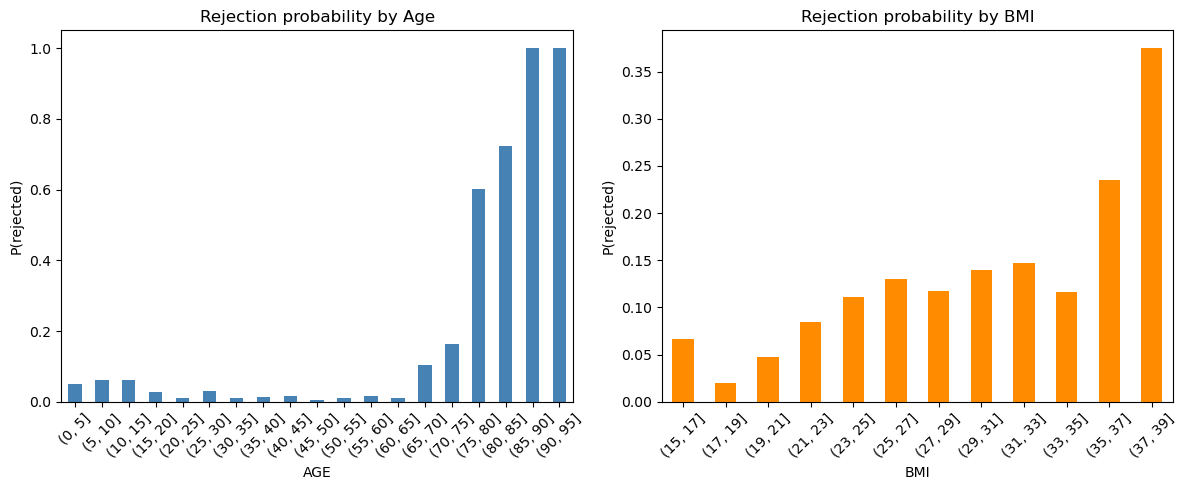

In [7]:
# Generate realistic population
population = sample_population(n_samples=10000)

# Ensure your rule table (rules_df) and decide_and_learn() exist
# LEARN_FLAG should be False for pure analysis
LEARN_FLAG = False

results = []

for i, row in tqdm(population.iterrows(), total=len(population)):
    x_input = {
        'BMI': row['BMI'],
        'AGE': row['AGE'],
        'SMOKER': row['SMOKER'],
        'PRACTICE_SPORT': row['PRACTICE_SPORT']
    }
    decision, ideal, _ = decide_and_learn(rules_df, x_input)
    results.append({
        "AGE": x_input['AGE'],
        "BMI": x_input['BMI'],
        "REJECTED": int(ideal == "rejected")
    })

results_df = pd.DataFrame(results)

# --------------------------------------------------
# 3. Plot Rejection Probability by Age and BMI
# --------------------------------------------------
age_bins = np.arange(0, 96, 5)
bmi_bins = np.arange(15, 41, 2)

age_rejection = results_df.groupby(pd.cut(results_df['AGE'], age_bins))['REJECTED'].mean()
bmi_rejection = results_df.groupby(pd.cut(results_df['BMI'], bmi_bins))['REJECTED'].mean()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
age_rejection.plot(kind='bar', color='steelblue')
plt.ylabel("P(rejected)")
plt.title("Rejection probability by Age")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
bmi_rejection.plot(kind='bar', color='darkorange')
plt.ylabel("P(rejected)")
plt.title("Rejection probability by BMI")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- 1. Generate population ---
population = sample_population(n_samples=10_000)

# --- 2. Compute decisions ---
results = []

for i, row in tqdm(population.iterrows(), total=len(population)):
    x_input = {
        'BMI': row['BMI'],
        'AGE': row['AGE'],
        'SMOKER': row['SMOKER'],
        'PRACTICE_SPORT': row['PRACTICE_SPORT']
    }
    _, decision, _ = decide_and_learn(rules_df, x_input)
    results.append({
        "AGE": x_input['AGE'],
        "BMI": x_input['BMI'],
        "DECISION": decision
    })

results_df = pd.DataFrame(results)

# --- 3. Bin AGE and BMI ---
age_bins = np.arange(0, 96, 5)
bmi_bins = np.arange(15, 41, 2)

results_df['AGE_BIN'] = pd.cut(results_df['AGE'], age_bins)
results_df['BMI_BIN'] = pd.cut(results_df['BMI'], bmi_bins)

# --- 4. Compute probabilities for each decision class ---
decision_classes = ["accepted", "accepted with extra charge", "need for additional information", "rejected"]
decision_colors = {
    "accepted": "green",
    "accepted with extra charge": "yellow",
    "need for additional information": "lightsalmon",
    "rejected": "red"
}

# AGE probabilities
age_prob = results_df.groupby(['AGE_BIN', 'DECISION']).size().unstack(fill_value=0)
age_prob = age_prob.div(age_prob.sum(axis=1), axis=0)

# BMI probabilities
bmi_prob = results_df.groupby(['BMI_BIN', 'DECISION']).size().unstack(fill_value=0)
bmi_prob = bmi_prob.div(bmi_prob.sum(axis=1), axis=0)

# --- 5. Create stacked bar chart ---
fig = make_subplots(rows=1, cols=2, subplot_titles=("Decision by Age", "Decision by BMI"))

# Age plot
for decision in decision_classes:
    if decision in age_prob.columns:
        fig.add_trace(
            go.Bar(
                x=[str(x) for x in age_prob.index],
                y=age_prob[decision],
                name=decision,
                marker_color=decision_colors[decision]
                # Removed text and textposition
            ),
            row=1, col=1
        )

# BMI plot
for decision in decision_classes:
    if decision in bmi_prob.columns:
        fig.add_trace(
            go.Bar(
                x=[str(x) for x in bmi_prob.index],
                y=bmi_prob[decision],
                name=decision,
                marker_color=decision_colors[decision],
                showlegend=False
                # Removed text and textposition
            ),
            row=1, col=2
        )


# --- 6. Update layout ---
fig.update_layout(
    barmode='stack',
    height=500, width=1000,
    yaxis=dict(title="Probability", range=[0, 1]),
    yaxis2=dict(title="Probability", range=[0, 1]),
    xaxis=dict(title="Age"),
    xaxis2=dict(title="Body Mass Index"),
    margin=dict(t=50, l=50, r=50, b=50),
    title_text="Decision Probabilities by Age and BMI",
    title_x=0.5
)

fig.show()


100%|██████████| 10000/10000 [03:25<00:00, 48.58it/s]
/var/folders/c7/b5mb_26139g62pw0_6zk4js00000gn/T/ipykernel_29914/3789426607.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_prob = results_df.groupby(['AGE_BIN', 'DECISION']).size().unstack(fill_value=0)
/var/folders/c7/b5mb_26139g62pw0_6zk4js00000gn/T/ipykernel_29914/3789426607.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_prob = results_df.groupby(['BMI_BIN', 'DECISION']).size().unstack(fill_value=0)


# PIE CHARTs EXPLAINING REJECTIONS
For rejections, I would like to display the different features as pie charts
How many smokers vs non smokers
How many active vs non sport
How many for the different BMI classes

In [15]:
results_df['DECISION'].value_counts()

DECISION
accepted                           5005
accepted with extra charge         3382
rejected                           1085
need for additional information     528
Name: count, dtype: int64

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: DECISION, Length: 10000, dtype: bool

In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Filter rejected applicants
rejected = population.loc[results_df['DECISION'] == 'rejected'].copy()

# Add BMI classes
bmi_classes = pd.cut(
    rejected['BMI'],
    bins=[0, 18.5, 25, 30, 100],
    labels=["Underweight", "Normal", "Overweight", "Obese"]
)
rejected['BMI_CLASS'] = bmi_classes

# --- Pie chart 1: Smoking Status ---
smoker_counts = rejected['SMOKER'].value_counts().reset_index()
smoker_counts.columns = ['SMOKER', 'count']
smoker_counts['SMOKER'] = smoker_counts['SMOKER'].map({True: "Smoker", False: "Non-Smoker"})

fig_smoker = px.pie(
    smoker_counts,
    names='SMOKER',
    values='count',
    color='SMOKER',
    color_discrete_map={"Smoker": "#ff7f0e", "Non-Smoker": "#1f77b4"},
    hole=0.2
)
fig_smoker.update_traces(textposition='inside', textinfo='percent+label')

# --- Pie chart 2: Physical Activity ---
sport_counts = rejected['PRACTICE_SPORT'].value_counts().reset_index()
sport_counts.columns = ['PRACTICE_SPORT', 'count']
sport_counts['PRACTICE_SPORT'] = sport_counts['PRACTICE_SPORT'].map({True: "Active", False: "Non-Active"})

fig_sport = px.pie(
    sport_counts,
    names='PRACTICE_SPORT',
    values='count',
    color='PRACTICE_SPORT',
    color_discrete_map={"Active": "#2ca02c", "Non-Active": "#d62728"},
    hole=0.2
)
fig_sport.update_traces(textposition='inside', textinfo='percent+label')

# --- Pie chart 3: BMI Class ---
bmi_counts = rejected['BMI_CLASS'].value_counts().sort_index().reset_index()
bmi_counts.columns = ['BMI_CLASS', 'count']

fig_bmi = px.pie(
    bmi_counts,
    names='BMI_CLASS',
    values='count',
    color='BMI_CLASS',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hole=0.2
)
fig_bmi.update_traces(textposition='inside', textinfo='percent+label')

# --- Side-by-side subplots ---
fig = make_subplots(
    rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
    subplot_titles=("Smoking", "Activity", "BMI")
)

# Add pie traces
fig.add_trace(fig_smoker.data[0], row=1, col=1)
fig.add_trace(fig_sport.data[0], row=1, col=2)
fig.add_trace(fig_bmi.data[0], row=1, col=3)

# Update layout: center main title, increase font size, and lower subplot titles
fig.update_layout(
    height=500, width=1000,
    title=dict(
        text="Rejections Overview",
        x=0.5,          # center
        xanchor='center',
        yanchor='top',
        font=dict(size=24)  # larger main title
    ),
    showlegend=True,
)

# Lower the subplot titles (Smoking, Activity, BMI) a bit
for annotation in fig['layout']['annotations']:
    annotation['y'] = 0.95  # lower slightly above the pies
    annotation['font'] = dict(size=16)  # optional: adjust font size for subplot titles


fig.show()


# Impact of Rules Update

Before implementing a new set of rules it's crucial to understand what impact those new rules will have on the decisions taken. More specifically we want to discover here what amount of contract will the rules update affect, which ones, and generate some beautiful visualization for a dashboard analysis. 

Number of contract that change rule, composition of decisions made, contract affected.
Probably a Pie chart will do the job.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_rule_changes(old_rules_df: pd.DataFrame, new_rules_df: pd.DataFrame):
    """
    Compare old and new decision tables to analyze the impact of updated rules.
    """

    # 1. Ensure both dataframes have the same structure and align by index
    if not all(col in new_rules_df.columns for col in old_rules_df.columns):
        raise ValueError("New rules table is missing required columns.")

    merged = old_rules_df.copy()
    merged = merged.reset_index(drop=True)
    new_rules_df = new_rules_df.reset_index(drop=True)

    # Ensure same length: trim or pad if needed
    min_len = min(len(merged), len(new_rules_df))
    merged = merged.iloc[:min_len]
    new_rules_df = new_rules_df.iloc[:min_len]

    merged['OLD_DECISION'] = merged['DECISION']
    merged['NEW_DECISION'] = new_rules_df['DECISION']

    # 2. Identify changed decisions
    merged['CHANGED'] = merged['OLD_DECISION'] != merged['NEW_DECISION']
    changed = merged[merged['CHANGED']].copy()

    if changed.empty:
        print("No decision changes detected.")
        return

    # 3. Print summary statistics
    total_changes = len(changed)
    print(f"Total decision changes: {total_changes}")
    print(changed[['BMI', 'AGE', 'SMOKER', 'PRACTICE_SPORT', 'OLD_DECISION', 'NEW_DECISION']])

    # 4. Directional change analysis
    changed['CHANGE_TYPE'] = changed.apply(lambda r: f"{r['OLD_DECISION']} → {r['NEW_DECISION']}", axis=1)
    change_summary = changed['CHANGE_TYPE'].value_counts()
    print("\nChange breakdown:")
    print(change_summary)

    # 5. Pie charts for changed decisions
    def pie_chart(ax, data, labels, title, colors=None):
        ax.pie(
            data.value_counts(),
            labels=labels or data.value_counts().index,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors
        )
        ax.set_title(title)

    # Add BMI class
    changed['BMI_CLASS'] = pd.cut(
        changed['BMI'],
        bins=[0, 18.5, 25, 30, 100],
        labels=["Underweight", "Normal", "Overweight", "Obese"]
    )

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    pie_chart(axes[0], changed['SMOKER'], ["Smoker", "Non-Smoker"], "Changed Decisions: Smoking Status", ['#ff7f0e', '#1f77b4'])
    pie_chart(axes[1], changed['PRACTICE_SPORT'], ["Active", "Non-Active"], "Changed Decisions: Physical Activity", ['#2ca02c', '#d62728'])
    pie_chart(axes[2], changed['BMI_CLASS'], None, "Changed Decisions: BMI Category", plt.cm.Paired.colors)
    plt.tight_layout()
    plt.show()

    # 6. Bar plot for direction of change
    plt.figure(figsize=(6, 4))
    change_summary.plot(kind='bar', color='#1f77b4')
    plt.title("Direction of Decision Changes")
    plt.ylabel("Count")
    plt.xlabel("Change Type")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return changed


Total decision changes: 3
   BMI  AGE  SMOKER  PRACTICE_SPORT                     OLD_DECISION  \
1   30   45    True           False       accepted with extra charge   
2   27   35   False           False  need for additional information   
5   25   40    True            True       accepted with extra charge   

  NEW_DECISION  
1     rejected  
2     accepted  
5     accepted  

Change breakdown:
CHANGE_TYPE
accepted with extra charge → rejected         1
need for additional information → accepted    1
accepted with extra charge → accepted         1
Name: count, dtype: int64


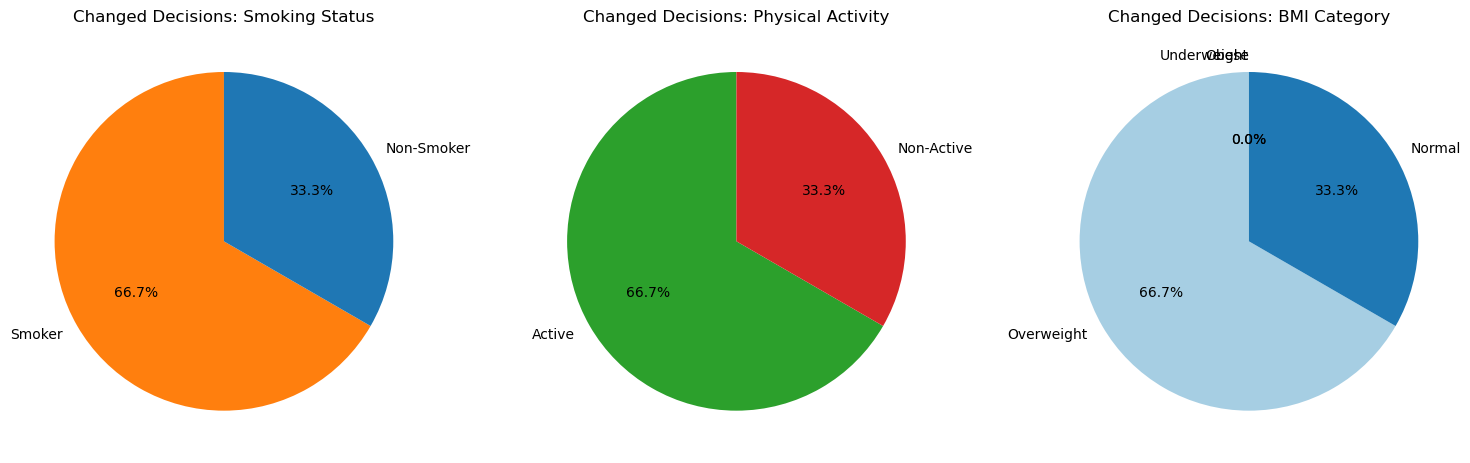

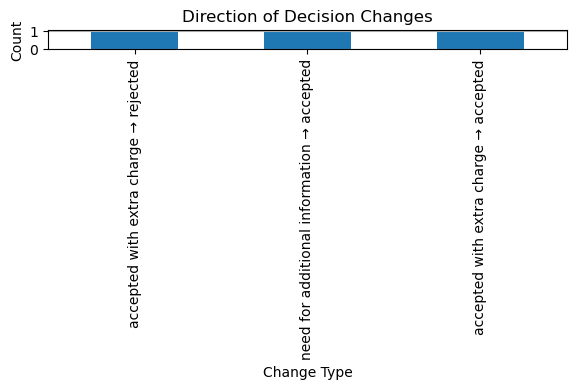

In [21]:
import pandas as pd

# --- Example: Old rules table ---
rules_data = [
    [22, 25, False, True,  "accepted", "nothing special, young healthy non-smoker practicing sport"],
    [30, 45, True,  False, "accepted with extra charge", "smoker with moderate BMI, increased premium risk"],
    [27, 35, False, False, "need for additional information", "unclear risk profile, needs more info"],
    [35, 55, True,  False, "rejected", "rejected because of too high risk due to age and smoking"],
    [19, 20, False, True,  "accepted", "nothing special, fit young individual"],
    [25, 40, True,  True,  "accepted with extra charge", "smoker despite doing sports, small surcharge"]
]

old_rules_df = pd.DataFrame(
    rules_data,
    columns=["BMI", "AGE", "SMOKER", "PRACTICE_SPORT", "DECISION", "COMMENT"]
)

# --- Example: New rules table (some decisions change) ---
new_rules_data = [
    [22, 25, False, True,  "accepted", "unchanged, still good risk"],
    [30, 45, True,  False, "rejected", "policy tightened for middle-aged smokers"],
    [27, 35, False, False, "accepted", "now accepted due to lower BMI threshold"],
    [35, 55, True,  False, "rejected", "unchanged, high risk"],
    [19, 20, False, True,  "accepted", "unchanged"],
    [25, 40, True,  True,  "accepted", "no surcharge anymore for sporty smokers"]
]

new_rules_df = pd.DataFrame(
    new_rules_data,
    columns=["BMI", "AGE", "SMOKER", "PRACTICE_SPORT", "DECISION", "COMMENT"]
)

# --- Run the analysis ---
changed = analyze_rule_changes(old_rules_df, new_rules_df)


100%|██████████| 4000/4000 [00:01<00:00, 3529.96it/s]


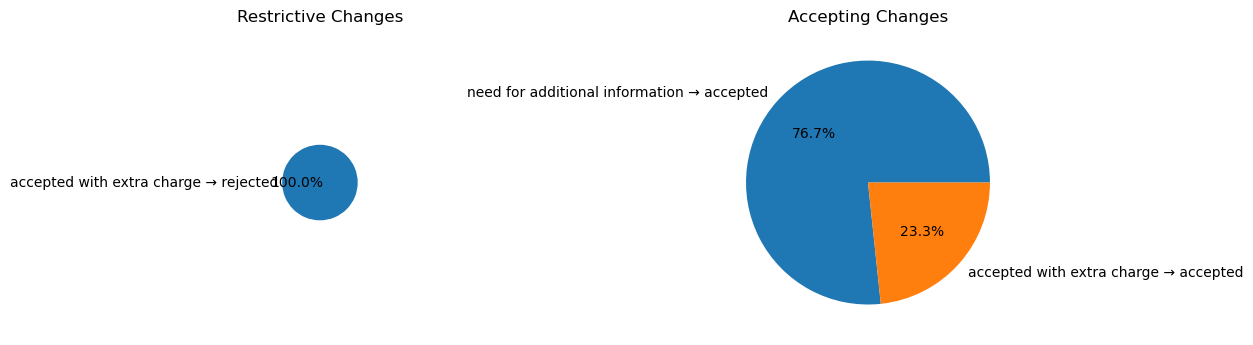

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------------------------------------
# 2. Monte Carlo comparison between rule sets
# ------------------------------------------------------------
def compare_rules_montecarlo(rules_old, rules_new, decide_func, n_samples=4000):
    population = sample_population(n_samples)
    results = []

    for i, row in tqdm(population.iterrows(), total=n_samples):
        x = row.to_dict()
        decision_old, _ , _= decide_func(rules_old, x)
        decision_new, _ , _= decide_func(rules_new, x)

        results.append({
            'AGE': x['AGE'],
            'BMI': x['BMI'],
            'SMOKER': x['SMOKER'],
            'PRACTICE_SPORT': x['PRACTICE_SPORT'],
            'OLD_DECISION': decision_old,
            'NEW_DECISION': decision_new
        })

    df = pd.DataFrame(results)
    df['CHANGED'] = df['OLD_DECISION'] != df['NEW_DECISION']
    return df


# ------------------------------------------------------------
# 3. Visualization
# ------------------------------------------------------------
def visualize_rule_diff_ranked_scaled(df):
    # Decision rank
    rank_order = ["accepted", "accepted with extra charge", "need for additional information", "rejected"]
    rank_dict = {k: i for i, k in enumerate(rank_order)}

    # Only changed decisions
    changed_df = df[df['CHANGED']].copy()
    if changed_df.empty:
        print("No changed decisions — skipping visualization.")
        return

    # Determine direction
    def change_direction(row):
        old_rank = rank_dict[row['OLD_DECISION']]
        new_rank = rank_dict[row['NEW_DECISION']]
        if new_rank > old_rank:
            return "Restrictive"
        elif new_rank < old_rank:
            return "Accepting"
        else:
            return "Unchanged"

    changed_df['DIRECTION'] = changed_df.apply(change_direction, axis=1)

    # Separate into restrictive vs accepting
    restrictive = changed_df[changed_df['DIRECTION'] == "Restrictive"]
    accepting = changed_df[changed_df['DIRECTION'] == "Accepting"]

    # Figure with two pies side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Determine radius proportional to sqrt(count)
    max_count = max(len(restrictive), len(accepting), 1)  # avoid div by zero
    radius_restrictive = (len(restrictive) / max_count) ** 0.5
    radius_accepting = (len(accepting) / max_count) ** 0.5

    # Restrictive pie
    if not restrictive.empty:
        restrictive_pairs = restrictive[['OLD_DECISION', 'NEW_DECISION']].apply(lambda x: f"{x['OLD_DECISION']} → {x['NEW_DECISION']}", axis=1)
        restrictive_counts = restrictive_pairs.value_counts()
        axes[0].pie(restrictive_counts, labels=restrictive_counts.index, autopct='%1.1f%%', radius=radius_restrictive)
        axes[0].set_title(f"Restrictive Changes")
    else:
        axes[0].text(0.5, 0.5, 'No restrictive changes', ha='center', va='center')
        axes[0].set_title('Restrictive Changes')

    # Accepting pie
    if not accepting.empty:
        accepting_pairs = accepting[['OLD_DECISION', 'NEW_DECISION']].apply(lambda x: f"{x['OLD_DECISION']} → {x['NEW_DECISION']}", axis=1)
        accepting_counts = accepting_pairs.value_counts()
        axes[1].pie(accepting_counts, labels=accepting_counts.index, autopct='%1.1f%%', radius=radius_accepting)
        axes[1].set_title(f"Accepting Changes")
    else:
        axes[1].text(0.5, 0.5, 'No accepting changes', ha='center', va='center')
        axes[1].set_title('Accepting Changes')

    plt.tight_layout()
    plt.show()




# ------------------------------------------------------------
# 4. Example usage
# ------------------------------------------------------------
# --- Example: Old rules table ---
rules_data = [
    [22, 25, False, True,  "accepted", "nothing special, young healthy non-smoker practicing sport"],
    [30, 45, True,  False, "accepted with extra charge", "smoker with moderate BMI, increased premium risk"],
    [27, 35, False, False, "need for additional information", "unclear risk profile, needs more info"],
    [35, 55, True,  False, "rejected", "rejected because of too high risk due to age and smoking"],
    [19, 20, False, True,  "accepted", "nothing special, fit young individual"],
    [25, 40, True,  True,  "accepted with extra charge", "smoker despite doing sports, small surcharge"]
]

old_rules_df = pd.DataFrame(
    rules_data,
    columns=["BMI", "AGE", "SMOKER", "PRACTICE_SPORT", "DECISION", "COMMENT"]
)

# --- Example: New rules table (some decisions change) ---
new_rules_data = [
    [22, 25, False, True,  "accepted", "unchanged, still good risk"],
    [30, 45, True,  False, "rejected", "policy tightened for middle-aged smokers"],
    [27, 35, False, False, "accepted", "now accepted due to lower BMI threshold"],
    [35, 55, True,  False, "rejected", "unchanged, high risk"],
    [19, 20, False, True,  "accepted", "unchanged"],
    [25, 40, True,  True,  "accepted", "no surcharge anymore for sporty smokers"]
]

new_rules_df = pd.DataFrame(
    new_rules_data,
    columns=["BMI", "AGE", "SMOKER", "PRACTICE_SPORT", "DECISION", "COMMENT"]
)

# --- Run the analysis ---
results_df = compare_rules_montecarlo(old_rules_df, new_rules_df, decide_and_learn)
visualize_rule_diff_ranked_scaled(results_df)

In [23]:
results_df = compare_rules_montecarlo(old_rules_df, new_rules_df, decide_and_learn)
results_df

100%|██████████| 4000/4000 [00:01<00:00, 3559.26it/s]


,AGE,BMI,SMOKER,PRACTICE_SPORT,OLD_DECISION,NEW_DECISION,CHANGED
0,48,28.7,False,False,need for additional information,accepted,True
1,7,15.9,False,True,accepted,accepted,False
2,58,22.4,False,False,need for additional information,accepted,True
3,42,23.1,True,True,accepted with extra charge,accepted,True
4,3,13.2,False,True,accepted,accepted,False
...,...,...,...,...,...,...,...
3995,4,17.7,False,True,accepted,accepted,False
3996,37,25.7,False,False,need for additional information,accepted,True
3997,58,17.1,False,False,need for additional information,accepted,True
3998,58,23.5,False,False,need for additional information,accepted,True


In [24]:
import plotly.graph_objects as go
import plotly.express as px
import math

def visualize_rule_diff_ranked_scaled_px(df):
    # Decision rank
    rank_order = ["accepted", "accepted with extra charge", "need for additional information", "rejected"]
    rank_dict = {k: i for i, k in enumerate(rank_order)}

    # Emoji mapping
    emoji_map = {
        "accepted": "✅ok",                        # simple accepted
        "accepted with extra charge": "💰extra charges",    # accepted + money for extra charge
        "need for additional information": "❓more info", # question mark
        "rejected": "❌"                         # rejected
    }  

    # Only changed decisions
    changed_df = df[df['CHANGED']].copy()
    if changed_df.empty:
        print("No changed decisions — skipping visualization.")
        return

    # Determine direction
    def change_direction(row):
        old_rank = rank_dict[row['OLD_DECISION']]
        new_rank = rank_dict[row['NEW_DECISION']]
        if new_rank > old_rank:
            return "Restrictive"
        elif new_rank < old_rank:
            return "Accepting"
        else:
            return "Unchanged"

    changed_df['DIRECTION'] = changed_df.apply(change_direction, axis=1)
    changed_df['PAIR'] = changed_df['OLD_DECISION'] + " → " + changed_df['NEW_DECISION']

    # Replace labels with emojis
    def pair_to_emoji(pair):
        old, new = pair.split(" → ")
        return f"{emoji_map.get(old, old)} → {emoji_map.get(new, new)}"

    changed_df['PAIR_EMOJI'] = changed_df['PAIR'].apply(pair_to_emoji)

    # Prepare counts
    def prepare_counts(sub_df, default_label):
        if sub_df.empty:
            return [default_label], [1]
        counts = sub_df['PAIR_EMOJI'].value_counts()
        return counts.index.tolist(), counts.values.tolist()

    r_labels, r_values = prepare_counts(changed_df[changed_df['DIRECTION'] == "Restrictive"], "No restrictive changes")
    a_labels, a_values = prepare_counts(changed_df[changed_df['DIRECTION'] == "Accepting"], "No accepting changes")

    # Compute scaling factor for pie areas
    max_cases = max(sum(r_values), sum(a_values))
    r_scale = math.sqrt(sum(r_values) / max_cases)
    a_scale = math.sqrt(sum(a_values) / max_cases)

    # Pick darker colors
    def get_dark_colors(palette, n):
        step = max(len(palette)//n, 1)
        return palette[-n*step::step][:n]

    r_colors = get_dark_colors(px.colors.sequential.Reds[3:], len(r_labels))
    a_colors = get_dark_colors(px.colors.sequential.Greens[2:], len(a_labels))

    # Build figure
    fig = go.Figure()

    fig.add_trace(go.Pie(
        labels=r_labels,
        values=r_values,
        name="Restrictive",
        hole=0.2,
        textinfo='label+percent',
        insidetextorientation='radial',
        marker=dict(colors=r_colors),
        textfont_size=10  # bigger font
    ))

    fig.add_trace(go.Pie(
        labels=a_labels,
        values=a_values,
        name="Accepting",
        hole=0.2,
        textinfo='label+percent',
        insidetextorientation='radial',
        marker=dict(colors=a_colors),
        textfont_size=10  # bigger font
    ))

    # Scale pie area
    fig['data'][0]['domain'] = {'x': [0, 0.48], 'y': [0.5 - r_scale/2, 0.5 + r_scale/2]}
    fig['data'][1]['domain'] = {'x': [0.52, 1], 'y': [0.5 - 0.7*a_scale/2, 0.5 + 0.7*a_scale/2]}

    fig.update_layout(
        title_text="Rule Changes Overview",
        title_x=0.5,
        height=500,
        width=1000
    )

    fig.show()


# Impact of Rules Update

Before implementing a new set of rules it's crucial to understand what impact those new rules will have on the decisions taken. More specifically we want to discover here what amount of contract will the rules update affect, which ones, and generate some beautiful visualization for a dashboard analysis. 

Number of contract that change rule, composition of decisions made, contract affected.
Probably a Pie chart will do the job.

In [25]:
visualize_rule_diff_ranked_scaled_px(results_df)